# Task: Predicting Salary from a Job Posting

**Ming He**

**03-10-2018**

## Summary
* Step 1: import, inspect, clean the data, removed entry error
* Step 2: exploratory analysis to choose features
* Step 3: use four algorithms (lasso, ridge, random forest, gradient boosting regression) for prediction. For each algorithm, perform a small scale grid search on the tuning parameters, and the best of each algorithm are chosen and compared. Gradient boosting regression performs the best, with a relative error 16.7% (Relative error is the ratio between root mean squared error (RMSE) and average salary). As a benchmark solution, the relative error of a linear regression is roughly 17.0%.

### Structure of the Notebook

* Import raw data, sanity check, and clean the data 
* Exploratory analysis, choose features, prepare data for prediction
* Different prediction models, results, validation, and comparison

In [666]:
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_profiling
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline
import time
from sklearn import linear_model, ensemble
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

### Import Train Data and Sanity Check

In [667]:
train_features_raw = pd.read_csv('train_features_2013-03-07.csv')
train_features_raw.head(3)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38


In [519]:
train_features_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [668]:
train_salaries_raw = pd.read_csv('train_salaries_2013-03-07.csv')
train_salaries_raw.head(3)

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137


In [521]:
train_salaries_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [527]:
train_features_raw.shape,train_salaries_raw.shape
#Seems that the two data sets are perfectly matched in terms of shapes, let us join them.

((1000000, 8), (1000000, 2))

In [669]:
train_data_raw = train_features_raw.merge(train_salaries_raw, how = 'inner', left_on ='jobId', right_on = 'jobId')
train_data_raw.head(3)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137


In [526]:
train_data_raw.shape
#The number of rows stays the same after joining, so the two raw data sets are indeed perfectly matched in terms of 
#shapes.

(1000000, 9)

In [525]:
pandas_profiling.ProfileReport(train_data_raw,check_correlation=False)

Number of variables,9
Number of observations,1000000
Total Missing (%),0.0%
Total size in memory,76.3 MiB
Average record size in memory,80.0 B
Numeric,3
Categorical,5
Boolean,0
Date,0
Text (Unique),1
Rejected,0


### Observations from the above Profile
* **missing value**: no.
* **CompanyId**: there are only 63 companies for these 1 million job postings.
* **degree**: Proportion of jobs requiring at least a college degree is a little larger than the proportion that does not have this requirement (52.6% vs. 47.4%).
* **industry**: jobs in this data are evenly distributed across industries.
* **jobType**: evenly distributed across all the 8 job types.
* **major**: no major specification accounts for 53.2%, and roughly evenly distributed across all other specified majors.
* **milesFromMetropolis**: evenly distributed between 0 and 100, with both mean and median be around 50.
* **salary**: has a normal-like distribution, with mean and median both around 115K. From the report of its extrem values, there are 5 salary such as 0, let us look into it below.
* **yearsExperience**: mean and median both around 12 years, and has a large standard deviation (around 7 years).

Deep dive into the data with 0 salary

In [670]:
train_data_raw[train_data_raw['salary']==0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


A close inspection suggests that the 0 salary cases above should be due to entry error. (Values of other variables look regular, the salary should not be 0). Remove them and define our training data.

In [671]:
train_data_raw = train_data_raw[train_data_raw['salary']!=0]

### Exploratory Analysis to Determine Important Features for Salary Prediction

In [673]:
features = list(train_data_raw.columns)
features.remove('jobId')
features.remove('salary')
features

['companyId',
 'jobType',
 'degree',
 'major',
 'industry',
 'yearsExperience',
 'milesFromMetropolis']

### Plot Average Salary against Each Feature
The graph below plots the average salary in each bin of one variable, such as companyId, jobType, etc.
#### Summary From the Graph Below
* **companyId**: does not have a significant impact on the average salary, so we do not consider the company fixed effects for salary, i.e. do not include it in the train features.
* **jobType**: a strong indicator of the average salary, a CEO makes much more money than a Janitor (a good feature).
* **degree**: provide good information for the average salary, a worker with higher degree tends to make more money than one with a lower degree (a good feature).
* **major**: it seems that there is a difference between the group with major = None and otherwise. However, within the subgroup where major is not None, there do not seem to a big variation except for literature. We engineer a new feature called major_new, which takes four values: STEM, Business, Literature, None
* **industry**: there seems to be a lot of variation across industry (a good feature).
* **yearexperience**: positively correlated with the salary (a strong feature).
* **milesFromMetropolis**: negatively correlatd with the salary, this is due to the high living cost in metropolitan area (a good feature).

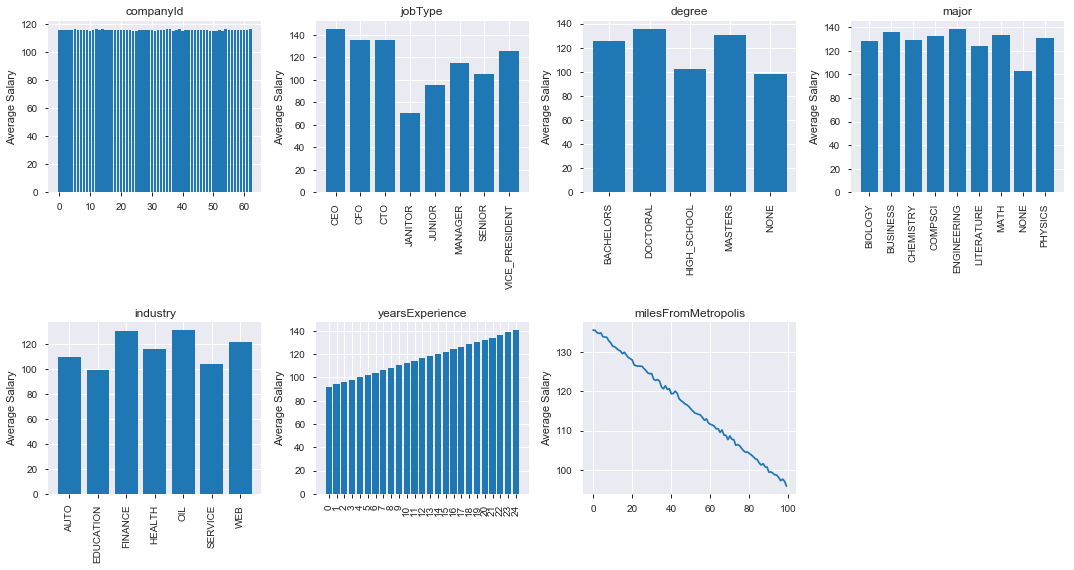

In [674]:
plt.figure(figsize = (15,8))
for i, feature in enumerate(features):
    
    salary_by = train_data_raw.groupby([feature])['salary'].agg('mean')
    feature_values = list(salary_by.keys())
    avg_salary = list(salary_by.values)
    plt.subplot(2,4,i+1)
    if feature == 'milesFromMetropolis':
        plt.plot(feature_values, avg_salary, label=feature)
    else: 
        plt.bar(range(len(feature_values)),avg_salary,label = feature)
        
    if feature not in ['companyId','milesFromMetropolis']:
        plt.xticks(range(len(feature_values)),feature_values,rotation='vertical')
    plt.ylabel('Average Salary')
    plt.title(feature)
plt.tight_layout(pad=1, w_pad=1, h_pad=2)
plt.show()

## Construct the Training Data

### Construct a New Feature of Major to Differentiate Between STEM, Business, Literature, None

It seems that there is a difference between the group with major = None and otherwise. However, within the subgroup where major is not None, there do not seem to a big variation except for literature. We engineer a new feature called major_new, which takes four values: STEM, Business, Literature, None.

In [676]:
majors = list(train_data_raw['major'].unique())
majors.remove('NONE')
majors.remove('LITERATURE')
majors.remove('BUSINESS')
stem_majors = majors

In [678]:
d = {stem_majors[i]:'STEM' for i in range(len(stem_majors))}
d.update({'BUSINESS':'BUSINESS','LITERATURE':'LITERATURE','NONE':'NONE'})
train_data = train_data_raw.assign(major_new=train_data_raw['major'].map(d))

In [679]:
train_data.head(3)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,major_new
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,STEM
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101,NONE
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137,STEM


### One-Hot Encoding Categorical Variables

* Numerize the categorical variables by one-hot encoding, an alternative is to do group by group. 
* We might also assign different numbers to different values of categorical variables. There are two potential shortcomings:
    * There might not be a natural order for a categorical variable, such as industry
    * For categorical variable that has a natural order, such as degree. If we map None to 0, High School to 1, Bachelor to 2, Master to 3, Ph.D. to 4. Then we are assuming linearity, while there might be intrinsic nonlinearity among the value of the degree.

In [540]:
train_data = train_data.drop(columns=['companyId','major','jobId'])
train_data_one_hot = pd.get_dummies(train_data, columns = ['jobType','degree','major_new','industry'], drop_first = True)
train_data_one_hot.head(3)

,yearsExperience,milesFromMetropolis,salary,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,...,degree_NONE,major_new_LITERATURE,major_new_NONE,major_new_STEM,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,10,83,130,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,3,73,101,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,10,38,137,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0


Define X_train and y_train

In [541]:
features = list(train_data_one_hot.columns)
features.remove('salary')
X_train = train_data_one_hot[features]
y_train = train_data_one_hot['salary']

The following function performs grid search over tuning parameters for the specified method.

In [584]:
def Grid_Search_CV(X_train, y_train, method, grid, cv = 3):
    '''
    This function performs grid search over tuning parameters for different methods
    Output: return the best predictor within a family of algorithm, best over the tuning parameters.
    '''
    start_time = time.time()
    if method == 'lasso':
        predictor = sk.linear_model.Lasso()
 
    if method == 'ridge':
        predictor = sk.linear_model.Ridge()
        
    if method == 'random_forest':
        predictor = sk.ensemble.RandomForestRegressor()
        
    if method == 'gbdt':
        predictor = sk.ensemble.GradientBoostingRegressor()
    
    grid_predictor = GridSearchCV(predictor, param_grid = grid, scoring = 'neg_mean_squared_error', cv = cv)
    grid_predictor.fit(X_train,y_train)
    
    duration = time.time() - start_time
    
    print("Time for {m}: {s:.2f} seconds".format(m=method,s=duration))
    
    return grid_predictor

#### Perform Grid Search for Lasso, Ridge, Random Forest, and GBDT

In [585]:
grid_lasso_ridge = {'alpha': list(np.logspace(-6, 2, 6))}
grid_rf_gbdt = {'max_depth': [3,4,5]}

methods = ['lasso','ridge','random_forest','gbdt']
predictors = []

for method in methods:
    if method in ['lasso','ridge']:
        tmp = Grid_Search_CV(X_train, y_train, method = method, grid=grid_lasso_ridge, cv = 5)
        predictors.append(tmp)
    if method in ['random_forest','gbdt']:
        tmp = Grid_Search_CV(X_train, y_train, method = method, grid=grid_rf_gbdt, cv = 5)
        predictors.append(tmp)

Time for lasso: 80.87 seconds
Time for ridge: 22.16 seconds
Time for random_forest: 113.70 seconds
Time for gbdt: 2019.19 seconds


#### Compare Performance of the Four Methods

In [586]:
average_salary = y_train.mean()
rmse, relative_error = [], []

for i in range(len(predictors)):
    tmp = np.round(np.sqrt(-predictors[i].best_score_),2)  #Use minus sign '-' since sklearn changed the scoring metric from 
                                                           #mean_squared_error to neg_mean_squared_error, need to convert it back
    rmse.append(tmp)
    relative_error.append(np.round(tmp/average_salary,3))
    
result = pd.DataFrame({'Method':methods,
                       'RMSE': rmse,
                       'Average Salary':[np.around(average_salary,2)]*4,
                       'Relative Error': relative_error})
columnsTitles=['Method','RMSE','Average Salary','Relative Error']
result=result.reindex(columns=columnsTitles)
result

,Method,RMSE,Average Salary,Relative Error
0,lasso,19.71,116.06,0.170
1,ridge,19.71,116.06,0.170
2,random_forest,26.73,116.06,0.230
3,gbdt,19.35,116.06,0.167


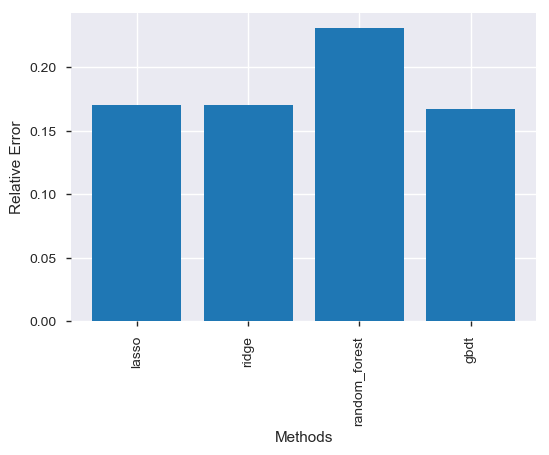

In [561]:
plt.figure(figsize = (6,4))
plt.bar(range(len(rmse)),relative_error)
plt.xlabel('Methods')
plt.ylabel('Relative Error')
plt.xticks(range(len(rmse)), methods, rotation = 'vertical')
plt.show()

Print the best predictor with the GBDT family

In [564]:
predictors[3].best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

From the above, we know that the GBDT method (with max_depth = 5) performs the best in terms of Mean Squared Error. Now let us further focus on this method. We need to know the feature importance by the GBDT. However, the GridSearchCV() method in sklearn does not provide us the attributes $feature_importances_$. In the following, we do a manual train test split and extract the feature importance.

In [587]:
X_train_manual, X_test_manual, y_train_manual, y_test_manual = train_test_split(X_train,y_train, test_size = 0.2)

Linear Regression

In [651]:
start_time = time.time()
lr = sk.linear_model.LinearRegression()
lr.fit(X_train_manual,y_train_manual)
duration = time.time()-start_time
print('computation time : {t:0.1f} seconds'.format(t=duration))

print('RMSE of Train Data is {t1:0.3f}'.format(t1=np.sqrt(np.mean((y_train_manual-lr.predict(X_train_manual))**2))))
print('RMSE of Test Data is {t2:0.3f}'.format(t2=np.sqrt(np.mean((y_test_manual-lr.predict(X_test_manual))**2))))

computation time : 0.6 seconds
RMSE of Train Data is 19.718
RMSE of Test Data is 19.694


GBDT

In [653]:
start_time = time.time()

GBDT = sk.ensemble.GradientBoostingRegressor(max_depth=5)
GBDT.fit(X_train_manual,y_train_manual)

duration = time.time()-start_time
print('computation time : {t:0.1f} seconds'.format(t=duration))
print('RMSE of Train Data is {t1:0.3f}'.format(t1=np.sqrt(np.mean((y_train_manual-GBDT.predict(X_train_manual))**2))))
print('RMSE of Test Data is {t2:0.3f}'.format(t2=np.sqrt(np.mean((y_test_manual-GBDT.predict(X_test_manual))**2))))

computation time : 179.8 seconds
RMSE of Train Data is 19.331
RMSE of Test Data is 19.340


The two have roughly the same error, we have good balance between training error and testing error.

### Plotting the Feature Importance

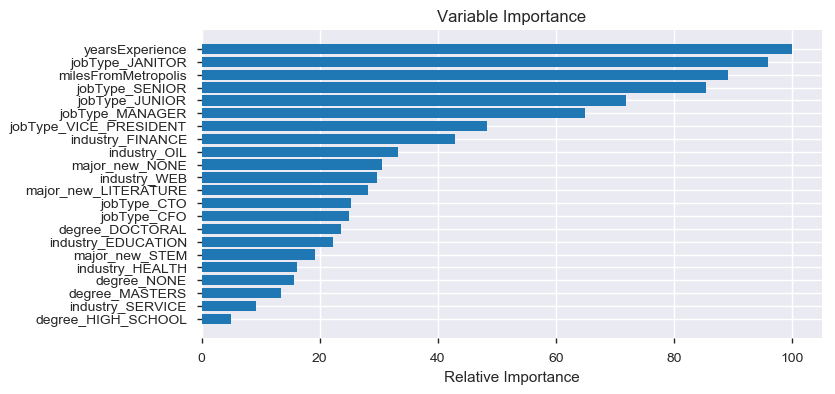

In [603]:
features = X_train.columns
plt.figure(figsize=(8, 4))
feature_importance = GBDT.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
feature_names = [features[i] for i in sorted_idx]
pos = np.arange(len(sorted_idx)) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Import Test Data

In [604]:
test_features_raw = pd.read_csv('test_features_2013-03-07.csv')

### Sanity Check of the data in test_features

In [605]:
pandas_profiling.ProfileReport(test_features_raw)

Number of variables,8
Number of observations,1000000
Total Missing (%),0.0%
Total size in memory,61.0 MiB
Average record size in memory,64.0 B
Numeric,2
Categorical,5
Boolean,0
Date,0
Text (Unique),1
Rejected,0


There are no missing values, we do not need to further clean it, and let us now predict the salary.

### Creating major_new and one-hot encoding Categorical Variables

In [606]:
d = {stem_majors[i]:'STEM' for i in range(len(stem_majors))}
d.update({'BUSINESS':'BUSINESS','LITERATURE':'LITERATURE','NONE':'NONE'})

test_features_raw = test_features_raw.assign(major_new = test_features_raw['major'].map(d))
test_features = test_features_raw.drop(columns=['companyId','major','jobId'])
test_features_one_hot = pd.get_dummies(test_features, columns = ['jobType','degree','major_new','industry'], drop_first = True)

In [607]:
features = list(test_features_one_hot.columns)
X_test = test_data_one_hot[features]
y_test = list(predictors[3].predict(X_test))
job_Id = list(test_features_raw['jobId'])

test_salaries = pd.DataFrame({'jobId':job_Id, 'salary':y_test})
test_salaries.to_csv('test_salaries.csv',index=False)

In [654]:
test_salaries = pd.read_csv('test_salaries.csv')
test_data = test_features_raw.merge(test_salary, how='inner', left_on ='jobId', right_on = 'jobId')

### Comparing Salary Distributions in Train Data and Test Data

In [655]:
train_salaries = train_salaries_raw[train_salaries_raw['salary'] != 0]

In [656]:
df_1 = train_salaries.describe()
df_2 = test_salaries.describe()
df_1=df_1.rename(index=str, columns={"salary": "train"})
df_2=df_2.rename(index=str, columns={"salary": "test"})
distribution_comparison = pd.concat([df_1, df_2], axis=1, join='inner')
distribution_comparison

,train,test
count,999995.000000,1000000.000000
mean,116.062398,116.061065
std,38.717163,32.490471
min,17.000000,24.426187
25%,88.000000,94.035320
50%,114.000000,117.114255
75%,141.000000,138.799176
max,301.000000,219.539903


**Comments**: The distributions of salary for train and test data are similar. In the predicted salary, there are no extreme or invalid values. Our predictions seem reasonable.

### Comparing Distributions of Predicted Salary with Those from Train Data
* Plot Average Salary against Each Feature for Train Data and Test Data

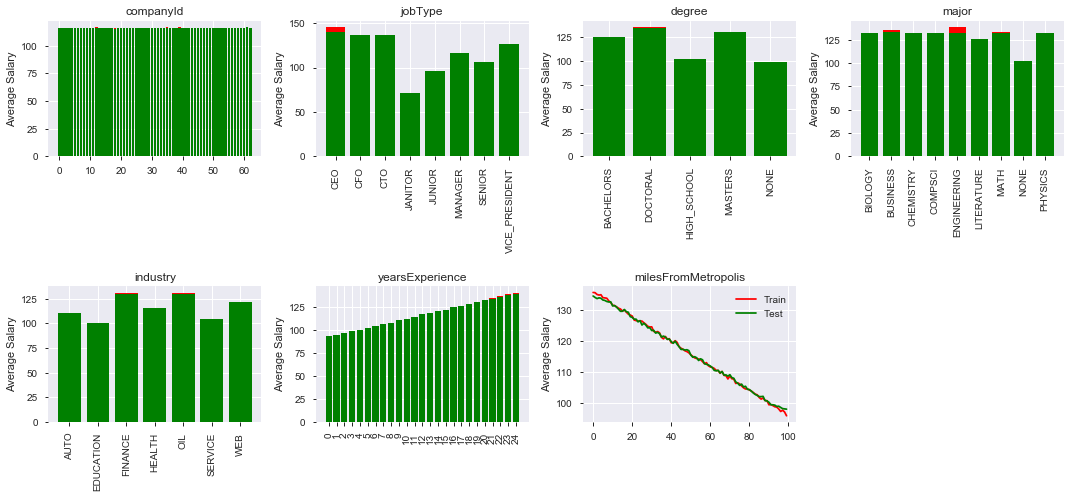

In [685]:
features = list(test_data.columns)
features.remove('jobId')
features.remove('salary')
features.remove('major_new')
features

plt.figure(figsize = (15,7))
for i, feature in enumerate(features):
    
    salary_by_train = train_data_raw.groupby([feature])['salary'].agg('mean')
    salary_by_test = test_data.groupby([feature])['salary'].agg('mean')
    
    feature_values = list(salary_by_train.keys())
    avg_salary_train = list(salary_by_train.values)
    avg_salary_test = list(salary_by_test.values)
    
    plt.subplot(2,4,i+1)
    if feature == 'milesFromMetropolis':
        plt.plot(feature_values, avg_salary_train, label='Train', color = "red")
        plt.plot(feature_values, avg_salary_test, label='Test', color = "green")
    else: 
        plt.bar(range(len(feature_values)),avg_salary_train,label = feature, color = 'red')
        plt.bar(range(len(feature_values)),avg_salary_test,label = feature, color = 'green')
        
    if feature not in ['companyId','milesFromMetropolis']:
        plt.xticks(range(len(feature_values)),feature_values,rotation='vertical')
    plt.ylabel('Average Salary')
    plt.title(feature)
plt.tight_layout(pad=1, w_pad=1, h_pad=2)
plt.legend()
plt.show()

**Comment**: The distributions of average salary in each group for the test data look similar to those in the train data. Our predictions seem to be reasonable.

### Suggestions for Further Improvement of the System

* City will be an important feature to include in future data collection
* Job searcher's information will be important to include to give a personalized prediction, can be obtained from the person's resume.